In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
import pickle
import pandas as pd
import random

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten


In [4]:
np.random.seed(0)

In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
    
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
    
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    
print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_val.shape[0] == y_val.shape[0])
assert(X_test.shape[0] == X_test.shape[0])

assert(X_train.shape[1:] == (32, 32, 3))
assert(X_val.shape[1:] == (32, 32, 3))
assert(X_test.shape[1:] == (32, 32, 3))


In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

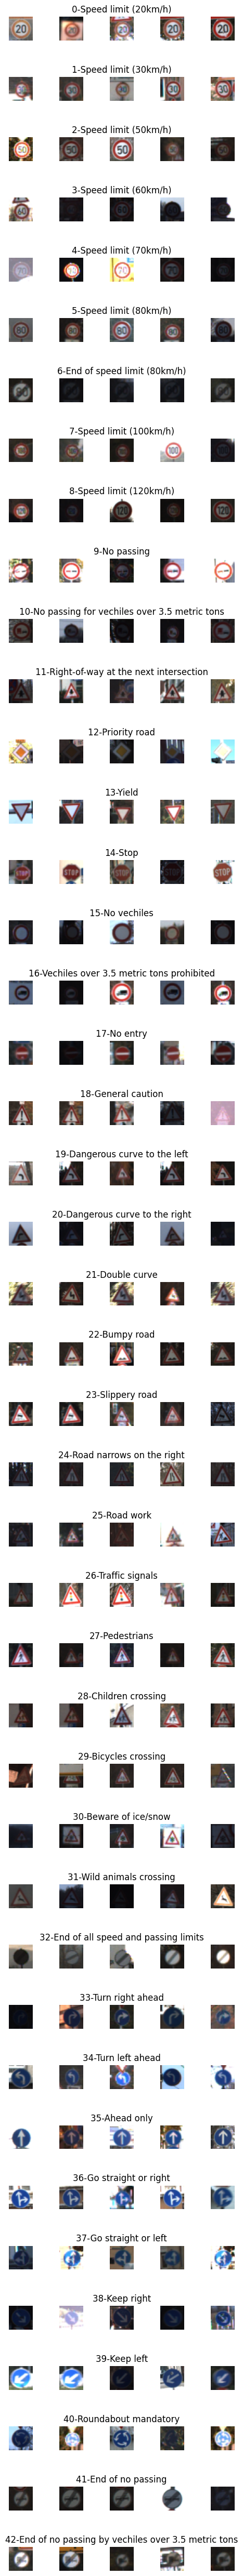

In [9]:
num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


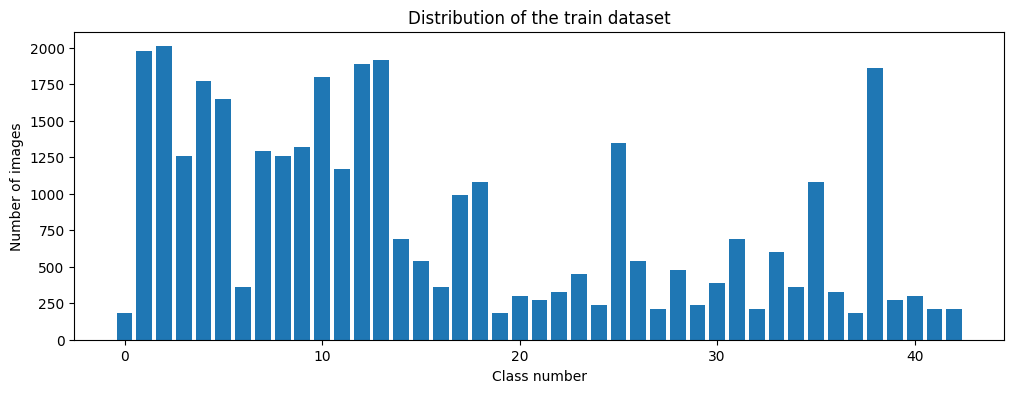

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


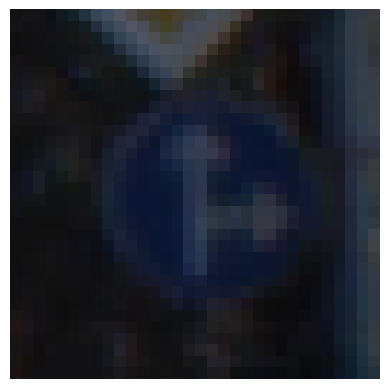

In [11]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


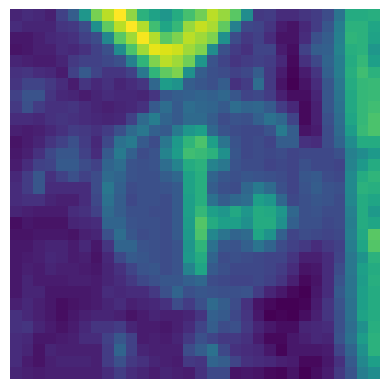

In [12]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img =  grayscale(X_train[1000])
plt.imshow(img)
# plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

(32, 32)


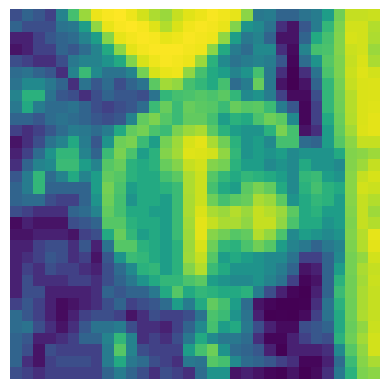

In [13]:
def equalize(img):
    img =cv2.equalizeHist(img)  #  technique for improving the contrast in images
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [14]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


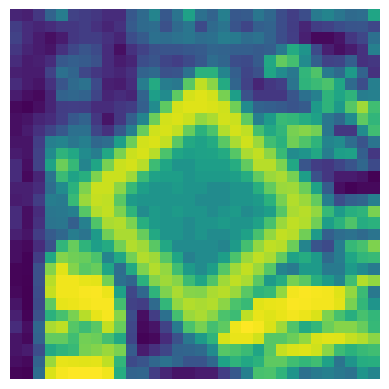

In [15]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [16]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10)

datagen.fit(X_train)

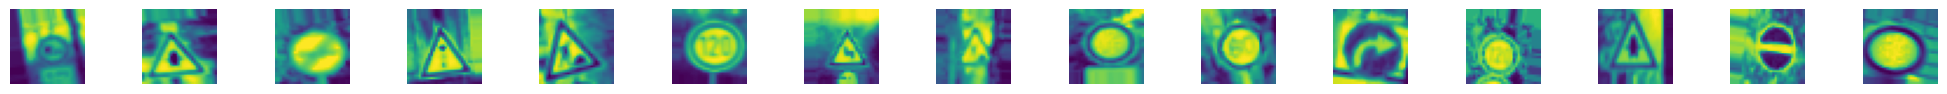

In [37]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis('off')

In [17]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [18]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [39]:
def leNet_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [40]:
model = leNet_model()
print(model.summary())

c:\python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [43]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
   1/2000 ━━━━━━━━━━━━━━━━━━━━ 1:34:34 3s/step - accuracy: 0.0200 - loss: 3.7516

c:\python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 696/2000 ━━━━━━━━━━━━━━━━━━━━ 1:22 64ms/step - accuracy: 0.3188 - loss: 2.4861

c:\python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.4487 - loss: 1.9670 - val_accuracy: 0.8937 - val_loss: 0.3556
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.8132 - loss: 0.6007 - val_accuracy: 0.9449 - val_loss: 0.1810
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.8884 - loss: 0.3570 - val_accuracy: 0.9633 - val_loss: 0.1275
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.9185 - loss: 0.2656 - val_accuracy: 0.9583 - val_loss: 0.1369
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 111s 55ms/step - accuracy: 0.9327 - loss: 0.2143 - val_accuracy: 0.9794 - val_loss: 0.0689
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 113s 56ms/step - accuracy: 0.9452 - loss: 0.1776 - val_accuracy: 0.9780 - val_loss: 0.0735
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 113s 56ms/step - accuracy: 0.9506 - loss: 0.1600 - val_accuracy: 0.9810 - val_loss: 0.0803
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 113s 56ms/step - accuracy: 0.9561 - loss: 

Text(0.5, 0, 'epoch')

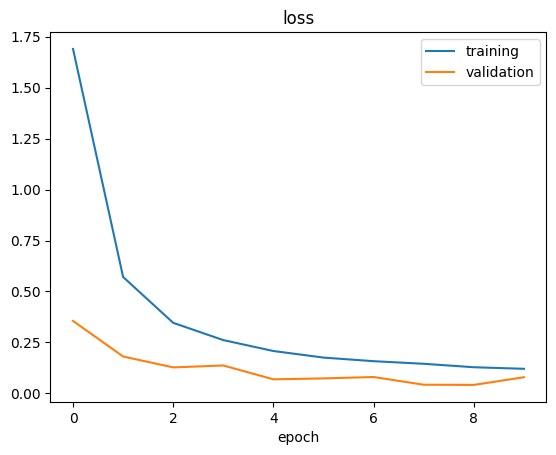

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("loss")
plt.xlabel('epoch')
# Validation loss should always lower then training loss

Text(0.5, 0, 'epoch')

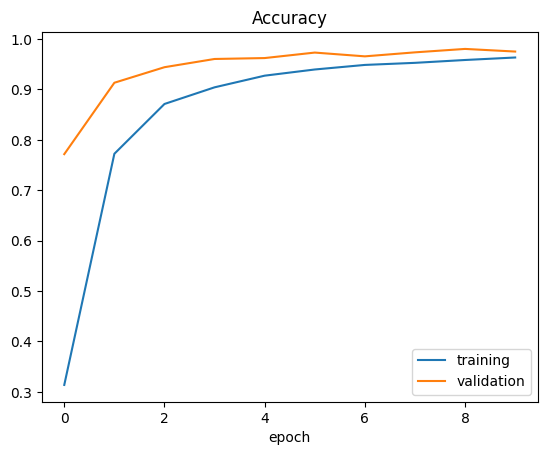

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel('epoch')
# Validation accuracy should be higher then training accuracy, if not then it is overfiting

In [47]:
model.evaluate(X_test, y_test, verbose = 0)

# print('Test Score:', score[0])
# print('Test Accuracy:', score[1])

[0.14559707045555115, 0.9650039672851562]

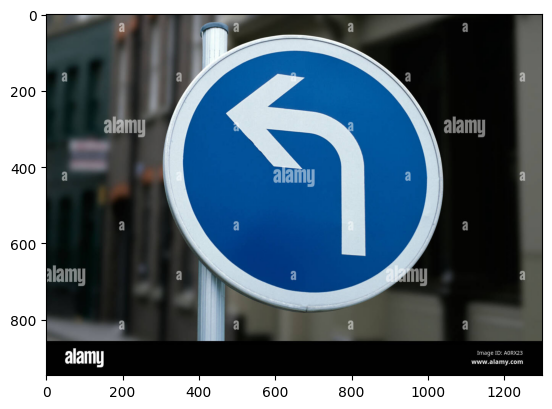

In [51]:
#fetch image
 
import requests
from PIL import Image
url = r'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 


(32, 32)


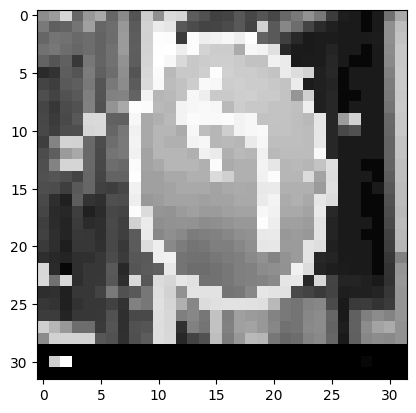

In [52]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)

In [54]:
#Test image
# print("predicted sign: "+ str(model.predict_classes(img)))

predictions = model.predict(img)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[12]
